In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_1d_compressed.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

In [2]:
device = torch.device("cuda")

prediction_time = 280 # 140 sec
measure_time = 120 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7
batch_size = 32

X = eta_hat[:, :-prediction_time, :]
y = eta_hat[:, prediction_time+measure_time:-1, :]

X = irfft(X)
y = irfft(y)

cut_index = np.argmin(np.abs(x-2000))
cut_index_2 = np.argmin(np.abs(x-2700))+1
X[:, :, cut_index:] = 0

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[:, 0*step:-measure_time+0*step-1],
    X[:, 1*step:-measure_time+1*step-1],
    X[:, 2*step:-measure_time+2*step-1],
    X[:, 3*step:-measure_time+3*step-1],
    X[:, 4*step:-measure_time+4*step-1],
    X[:, 5*step:-measure_time+5*step-1],
    X[:, 6*step:-measure_time+6*step-1],
], axis=2)

In [ ]:
# Creating dataset

for split in range(64, 65, 8):
    print("------- New Split -----", split)
    X_train = np.concatenate((X[:split-8].reshape(-1, 7, 1024), X[split:].reshape(-1, 7, 1024)))
    y_train = np.concatenate((y[:split-8].reshape(-1, 1024), y[split:].reshape(-1, 1024)))
    X_test = X[split-8:split].reshape(-1, 7, 1024)
    y_test = y[split-8:split].reshape(-1, 1024)

    # Only need std to normalize 

    std = np.std(X_train)
    X_train = X_train / std
    y_train = y_train / std

    np.save(f'results/std_{split}.npy', std)

    val_mask = np.zeros(X_train.shape[0], dtype=bool)
    val_mask[:int(0.1 * X_train.shape[0])] = True
    np.random.shuffle(val_mask)

    X_t = torch.from_numpy(X_train[~val_mask]).float()
    y_t = torch.from_numpy(y_train[~val_mask]).float()

    X_v = torch.from_numpy(X_train[val_mask]).float()
    y_v = torch.from_numpy(y_train[val_mask]).float()

    dataset = TensorDataset(X_t, y_t)
    loader  = DataLoader(dataset, batch_size=32, shuffle=True)

    dataset_val = TensorDataset(X_v, y_v)
    loader_val  = DataLoader(dataset_val, batch_size=32, shuffle=True)

    model     = FNO1d(in_channels=num_measurements+1, out_channels=1, width=32, modes=512, depth=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    early_stopping_rounds = 3

    early_stopping_count = 0
    best_loss = np.inf

    loss_mask = np.zeros(1024)
    loss_mask[cut_index:cut_index_2] = 1
    loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)
    loss_correction = 1024

    loss_train = []
    loss_val = []
    model.train()
    for epoch in range(1, 101):
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)

        total_loss_val = 0.0
        for xb, yb in loader_val:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
            total_loss_val += loss.item()
        avg_val = total_loss / len(loader_val)

        loss_train.append(avg)
        loss_val.append(avg_val)

        if avg_val < best_loss:
            best_loss = avg_val
            early_stopping_count = 0
            torch.save(model.state_dict(), f"results/best_FNO_1d_{split}_.pt")
            print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f} - Saving")
        else:
            print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f}")
            early_stopping_count += 1
            if early_stopping_count > early_stopping_rounds:
                print("early_stopping")
                break

(64, 1400, 7, 1024) (64, 1400, 1024)
------- New Split ----- 64
Epoch: 1, Loss train - 0.054781, Loss val - 0.493033 - Saving
Epoch: 2, Loss train - 0.009043, Loss val - 0.081383 - Saving
Epoch: 3, Loss train - 0.006102, Loss val - 0.054916 - Saving
Epoch: 4, Loss train - 0.004699, Loss val - 0.042293 - Saving
Epoch: 5, Loss train - 0.003914, Loss val - 0.035222 - Saving
Epoch: 6, Loss train - 0.003376, Loss val - 0.030386 - Saving
Epoch: 7, Loss train - 0.003020, Loss val - 0.027177 - Saving
Epoch: 8, Loss train - 0.002680, Loss val - 0.024119 - Saving
Epoch: 9, Loss train - 0.002570, Loss val - 0.023128 - Saving
Epoch: 10, Loss train - 0.002212, Loss val - 0.019912 - Saving
Epoch: 11, Loss train - 0.002081, Loss val - 0.018728 - Saving
Epoch: 12, Loss train - 0.001991, Loss val - 0.017918 - Saving
Epoch: 13, Loss train - 0.001854, Loss val - 0.016689 - Saving
Epoch: 14, Loss train - 0.001775, Loss val - 0.015972 - Saving
Epoch: 15, Loss train - 0.001665, Loss val - 0.014988 - Saving


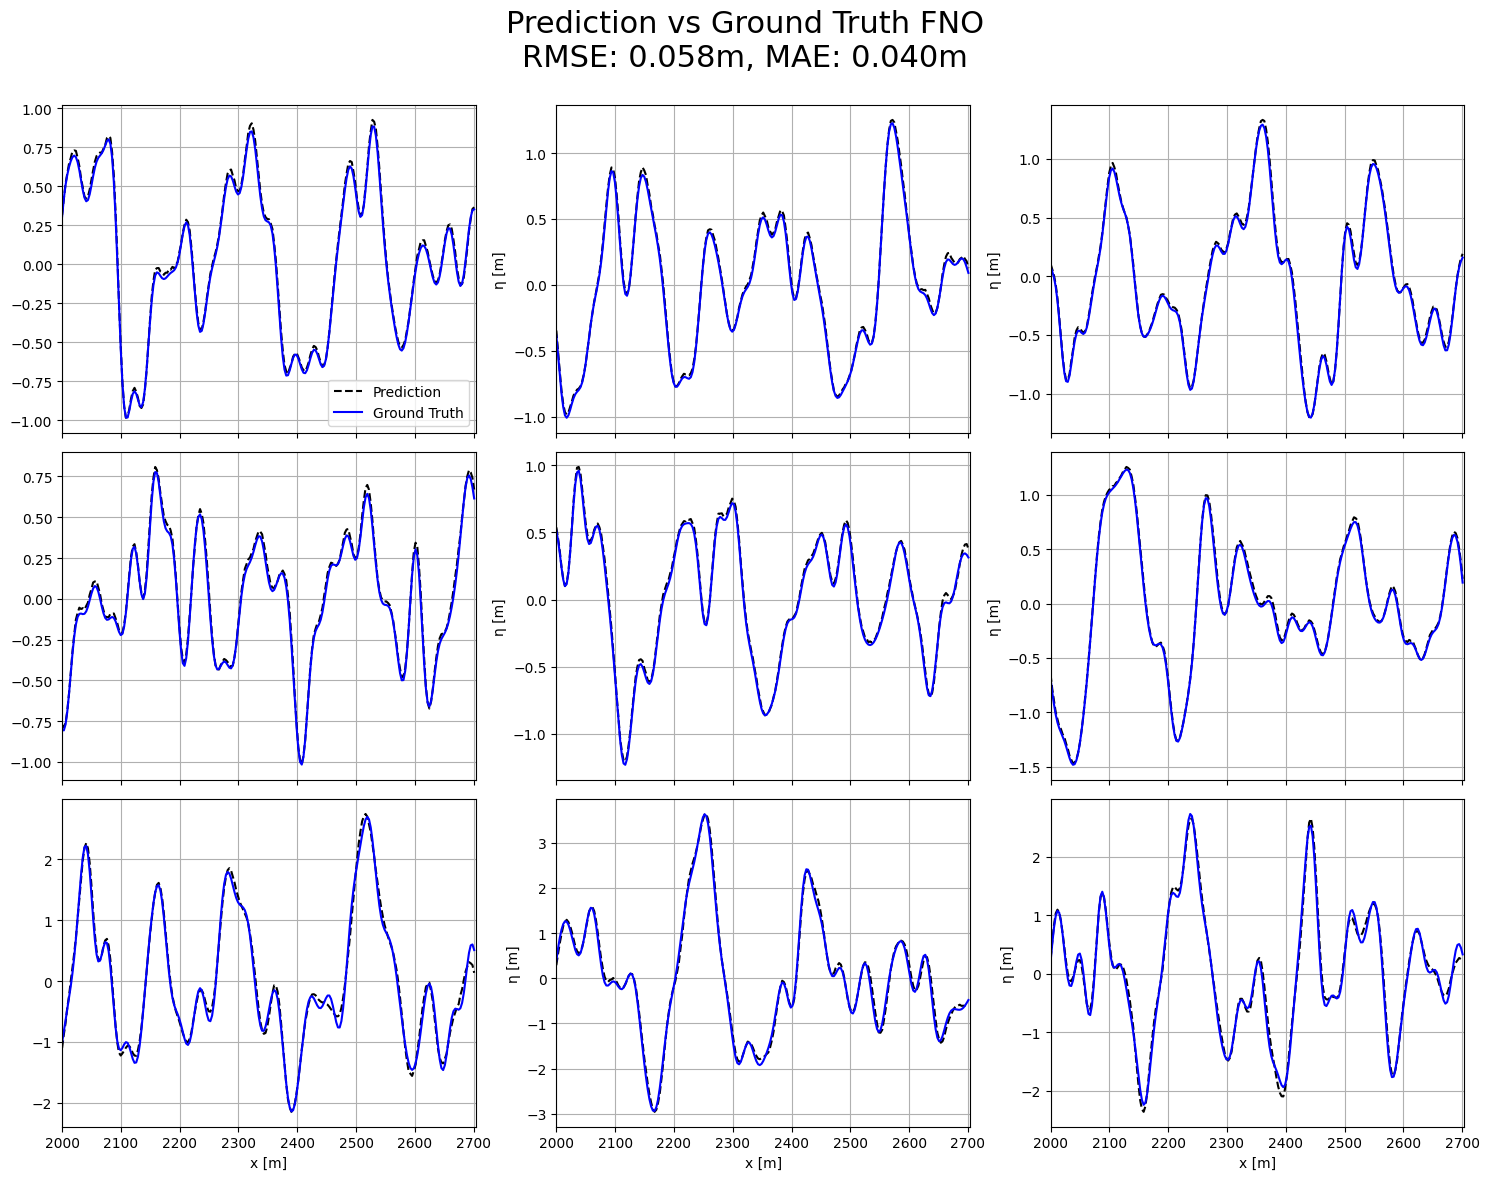

In [20]:
model = FNO1d(in_channels=num_measurements+1, out_channels=1, width=64, modes=512, depth=3).to(device)
model.load_state_dict(torch.load("best_FNO_1d_abs.pt", map_location=device))
model.eval() 

X_tensor = torch.from_numpy(X_test / std).float().to(device)
y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy() * std

y_pred_cut = y_pred[y_pred.shape[0]//3:]
y_test_cut = y_test[y_test.shape[0]//3:]

RMSE = np.sqrt(np.mean((y_pred_cut[:, cut_index:cut_index_2] - y_test_cut[:, cut_index:cut_index_2])**2))
MAE = np.mean(np.abs(y_pred_cut[:, cut_index:cut_index_2]-y_test_cut[:, cut_index:cut_index_2]))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Prediction vs Ground Truth FNO\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

for i, ax in enumerate(axes.flat):
    ax.plot(x[cut_index:cut_index_2], y_pred_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Prediction', color="k", linestyle="--")
    ax.plot(x[cut_index:cut_index_2], y_test_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Ground Truth', color="b")
    ax.grid(True)

    ax.grid(True)

    row, col = divmod(i, 3)
    
    if row == 2:
        ax.set_xlabel('x [m]')
    else:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('η [m]')

    if i == 0:
        ax.legend()

    ax.set_xlim(x[cut_index], x[cut_index_2])

    # ax.set_xlim(x[cut_index], x[cut_index_2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [3]:
gamma = [
         5.09876841, 5.08157858, 5.34864416, 5.63615218, 5.88708012, 5.01193477,
         5.93140696, 5.46903256, 5.66988397, 5.01676391, 5.76906378, 5.96412179,
         5.30964201, 5.27624417, 5.79561294, 5.7158428, 5.33764831, 5.26476746,
         5.53406432, 5.39710143, 5.15765819, 5.02806415, 5.77707532, 5.93618814,
         5.97176406, 5.98868139, 5.29880662, 5.82266746, 5.20731177, 5.54811277,
         5.71976428, 5.19888208, 5.41254766, 5.73148341, 5.15247344, 5.4681203,
         5.05118296, 5.30960503, 5.95435698, 5.17050983, 5.83577275, 5.53429938,
         5.70765999, 5.32937023, 5.78633074, 5.93428673, 5.95187918, 5.37549261,
         5.22108695, 5.98662534, 5.85279143, 5.77047338, 5.70352807, 5.67920045,
         5.43157037, 5.54620377, 5.79312688, 5.76241602, 5.18280772, 5.22227618,
         5.41266203, 5.89581313, 5.11454293, 5.21004316
         ]



------- New Split ----- 8
0
1
2
3
4
5
6
7
------- New Split ----- 16
8
9
10
11
12
13
14
15
------- New Split ----- 24
16
17
18
19
20
21
22
23
------- New Split ----- 32
24
25
26
27
28
29
30
31
------- New Split ----- 40
32
33
34
35
36
37
38
39
------- New Split ----- 48
40
41
42
43
44
45
46
47
------- New Split ----- 56
48
49
50
51
52
53
54
55
------- New Split ----- 64
56
57
58
59
60
61
62
63


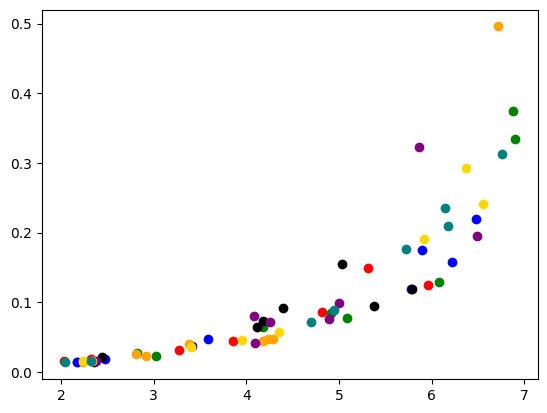

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d
import numpy as np

device = torch.device("cpu")

y_pred = np.zeros((64, *y.shape[-2:]))

colors = ["red", "green", "blue", "orange", "k", "purple", "gold", "teal"]

y_saved_ml = []
for split in range(8, 65, 8):
    print("------- New Split -----", split)
    model = FNO1d(in_channels=num_measurements+1, out_channels=1, width=32, modes=512, depth=3)
    model.load_state_dict(torch.load(f"results/best_FNO_1d_{split}.pt", map_location=torch.device('cpu')))
    model.eval() 

    std = np.load(f"results/std_{split}.npy")

    for index in range(split-8, split):
        print(index)
        X_test = X[index].reshape(-1, 7, 1024)
        y_test = y[index].reshape(-1, 1024)

        X_tensor = torch.from_numpy(X_test / std).float().to(device)
        with torch.no_grad():
            y_pred[index] = model(X_tensor).cpu().numpy() * std

        error = y_pred[index, :, cut_index:cut_index_2] - y_test[:, cut_index:cut_index_2]
        y_saved_ml.append(np.sqrt(np.mean(error**2)))
        plt.plot(Hs[index], np.sqrt(np.mean(error**2)), 'o', color=colors[split//8-1])
plt.show()

In [9]:
print(np.array(y_saved_ml).shape)
# np.save('rmse_ml_1d.npy', y_saved_ml)

(64,)


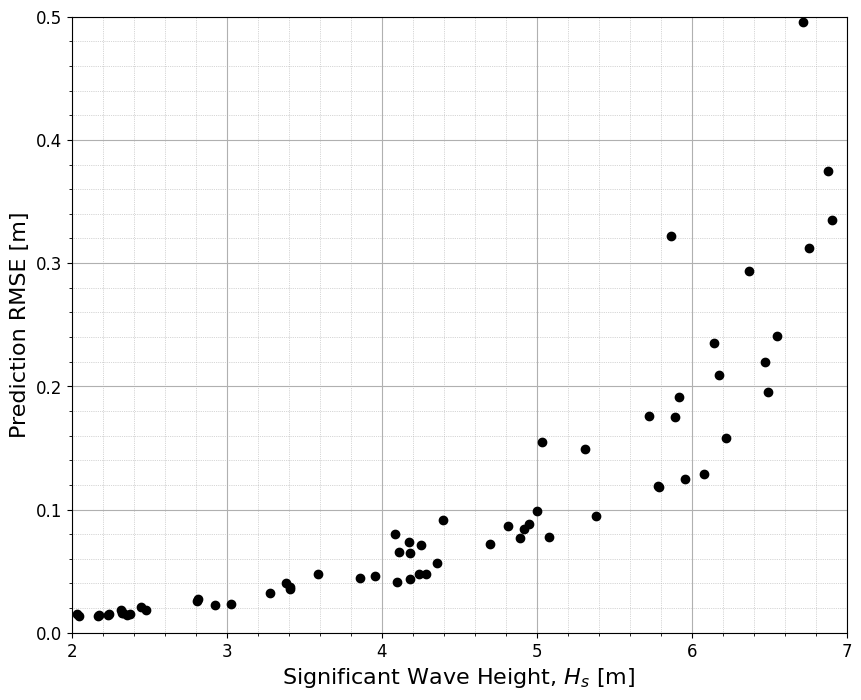

In [12]:
fontsize=16

fig, ax = plt.subplots(figsize=(10, 8))  # returns both fig and ax
for index in range(0, 64):
    error = y_pred[index, :, cut_index:cut_index_2] - y[index, :, cut_index:cut_index_2]
    if index == 0:
        plt.plot(Hs[index], np.sqrt(np.mean(error**2)), 'o', color="k", label="Mean RMSE Wavefield Realization")
    else:
        plt.plot(Hs[index], np.sqrt(np.mean(error**2)), 'o', color="k")

    # if index == 0:
    #     plt.plot(Hs[index], np.mean(np.abs(error)), 'x', color="k", label="MAE ML Prediction")
    # else:
    #     plt.plot(Hs[index], np.mean(np.abs(error)), 'x', color="k")
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=12)
plt.ylabel('Prediction RMSE [m]', fontsize=fontsize)
plt.xlabel('Significant Wave Height, $H_s$ [m]', fontsize=fontsize)
# plt.legend(fontsize=fontsize)

plt.xlim(2, 7)
plt.ylim(0, 0.5)
plt.savefig("results/1d_error_per_wavefield.pdf", dpi=300, bbox_inches='tight')
plt.show()
# plt.plot(np.mean(np.abs(y_pred[0, :, cut_index:cut_index_2] - y[0, :, cut_index:cut_index_2]), axis=1))

0 0.11068587856251119
1 0.11627031797089155
2 0.11104592819785951
3 0.1754725724663638
4 0.17290371843039415
5 0.1451778078823559
6 0.39667183194960337
7 0.2853594245229061
9 0.11273334673220535
10 0.29497196524271146
11 0.12489949398646126
12 0.2803912287440233
13 0.2111702564096187
14 0.23236614179344176
15 0.37635868097626474
16 0.12744014456196873
17 0.4136816927602582
18 0.26717795953621754
19 0.48568421204903134
20 0.4288135006300304
21 0.14144324187136154
22 0.15791775713249182
23 0.3799514279833626
24 0.14917791455713908
25 0.1484135133699277
26 0.5129263588132345
27 0.09686448457122261
28 0.20931369535935224
29 0.2304144307048174
30 0.19062257956515521
31 0.20844947677285483
32 0.37237003367040333
33 0.29065087952868407
34 0.16266224271293717
35 0.4049849155013676
36 0.26026923636434857
37 0.224496270583374
38 0.23474056248735883
39 0.07025329764390735
40 0.3386267842406224
41 0.2358799726400964
42 0.13797555854115254
43 0.2385687586708903
45 0.2522769041970887
47 0.3062922126

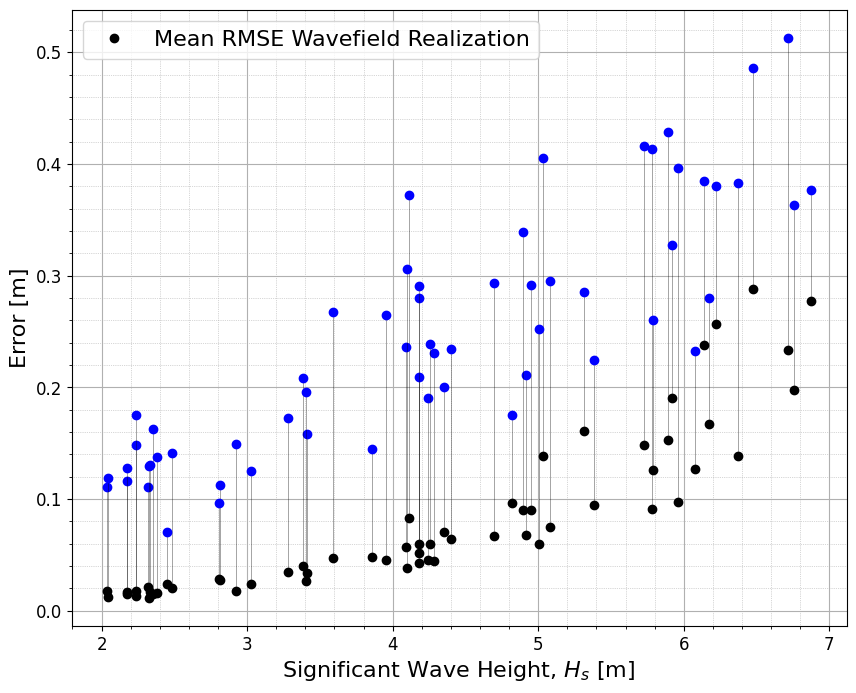

In [13]:
fontsize=16

Hs_result = []
Tp_result = []
gamma_result = []
RMS_result = []
MAE_result = []
error_result = []
index_result = []

for index in range(64):  
    data = np.load(f"save/1d_physical_{index}.npz")
    y_hat_ = data["y"]
    if np.isnan(y_hat_).sum() != 0: continue
    y_train_ = data["y_test"]
    y_ = irfft(y_hat_)

    error = y_train_[cut_index:cut_index_2] - y_[-1, 0, cut_index:cut_index_2]
    RMSE = np.sqrt(np.mean(error**2))
    MAE = np.mean(np.abs(error))
    if RMSE > 0.7:
        continue

    print(index, RMSE)

    Hs_result.append(Hs[index])
    Tp_result.append(Tp[index])
    gamma_result.append(gamma[index])
    RMS_result.append(RMSE)
    MAE_result.append(MAE)
    error_result.append(error)
    index_result.append(index)

    # plt.plot(y[-1, 0], "--", color="k")
    # plt.plot(y_train, "-", color="k")
    # plt.xlim(cut_index, cut_index_2)
    # plt.show()

Hs_result = np.array(Hs_result)
Tp_result = np.array(Tp_result)
RMS_result = np.array(RMS_result)
MAE_result = np.array(MAE_result)
error_result = np.array(error_result)

fig, ax = plt.subplots(figsize=(10, 8))  # returns both fig and ax
for i, index in enumerate(index_result):
    error = y_pred[index, 0, cut_index:cut_index_2] - y[index, 0, cut_index:cut_index_2]
    plt.plot([Hs_result[i], Hs_result[i]], [np.sqrt(np.mean(error**2)), RMS_result[i]], color='k', alpha=0.5, linewidth=0.5)
    if index == 0:
        plt.plot(Hs[index], np.sqrt(np.mean(error**2)), 'o', color="k", label="Mean RMSE Wavefield Realization")
    else:
        plt.plot(Hs[index], np.sqrt(np.mean(error**2)), 'o', color="k")

    plt.plot(Hs_result[i], RMS_result[i], 'o', color="b")
    
    

ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=12)
plt.ylabel('Error [m]', fontsize=fontsize)
plt.xlabel('Significant Wave Height, $H_s$ [m]', fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.savefig("results/1d_error_per_wavefield.pdf", dpi=300, bbox_inches='tight')
plt.show()
# plt.plot(np.mean(np.abs(y_pred[0, :, cut_index:cut_index_2] - y[0, :, cut_index:cut_index_2]), axis=1))

Hs: 2.32002472
Hs: 2.17607331
Hs: 2.03649012
Hs: 4.81686085
Hs: 3.27996651
Hs: 3.8604042
Hs: 5.95824263
Hs: 5.31192824


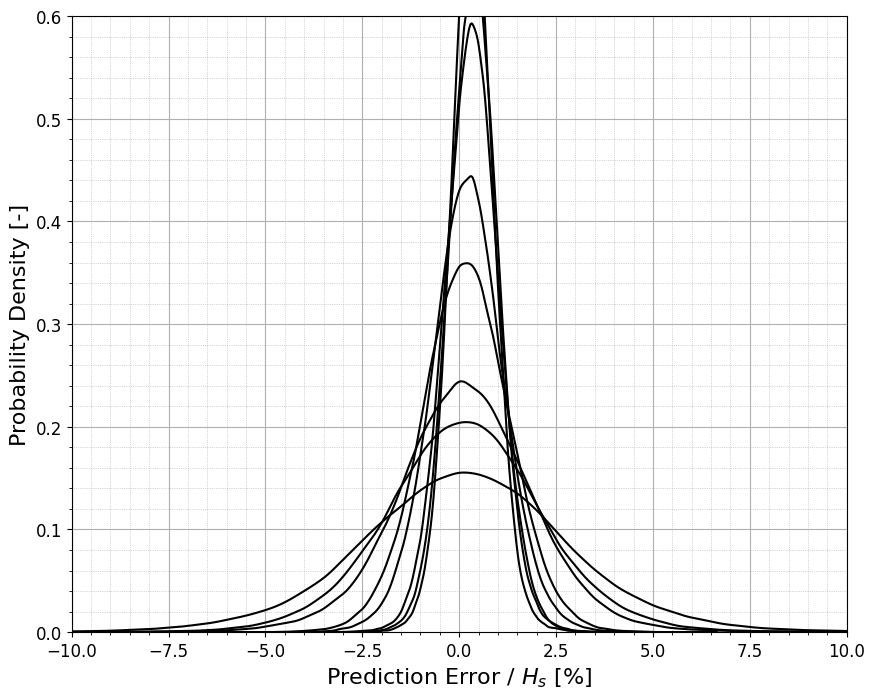

In [ ]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(10, 8))  # returns both fig and ax
for index in index_list:
    print("Hs:", Hs[index])
    data = ((y_pred[index, :, cut_index:cut_index_2] - y[index, :, cut_index:cut_index_2])/Hs[index]*100).flatten()

    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data) - 1, max(data) + 1, 1000)
    kde_vals = kde(x_vals)

    cdf = np.cumsum(kde_vals)
    cdf /= cdf[-1]

    lower_idx_95 = np.searchsorted(cdf, 0.025)
    upper_idx_95 = np.searchsorted(cdf, 0.975)
    ci_lower_95 = x_vals[lower_idx_95]
    ci_upper_95 = x_vals[upper_idx_95]


    plt.plot(x_vals, kde_vals, color="k")
    # plt.fill_between(x_vals, kde_vals, alpha=0.3, color="k")

# plt.axvline(ci_lower_90, label="90% Confidence Interval", linestyle="-", color="k")
# plt.axvline(ci_upper_90, linestyle="-", color="k")
# plt.axvline(ci_lower_95, label="95% Confidence Interval", linestyle="--", color="k")
# plt.axvline(ci_upper_95, linestyle="--", color="k")
plt.xlabel("Prediction Error / $H_s$ [%]", fontsize=fontsize)
plt.ylabel("Probability Density [-]", fontsize=fontsize)
plt.grid(True)
# plt.legend()
plt.ylim(0, 0.6)
plt.xlim(-10, 10)
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=12)
plt.savefig("results/kde_test.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
gamma = [5.09876841, 5.08157858, 5.34864416, 5.63615218, 5.88708012, 5.01193477,
         5.93140696, 5.46903256, 5.66988397, 5.01676391, 5.76906378, 5.96412179,
         5.30964201, 5.27624417, 5.79561294, 5.7158428, 5.33764831, 5.26476746,
         5.53406432, 5.39710143, 5.15765819, 5.02806415, 5.77707532, 5.93618814,
         5.97176406, 5.98868139, 5.29880662, 5.82266746, 5.20731177, 5.54811277,
         5.71976428, 5.19888208, 5.41254766, 5.73148341, 5.15247344, 5.4681203,
         5.05118296, 5.30960503, 5.95435698, 5.17050983, 5.83577275, 5.53429938,
         5.70765999, 5.32937023, 5.78633074, 5.93428673, 5.95187918, 5.37549261,
         5.22108695, 5.98662534, 5.85279143, 5.77047338, 5.70352807, 5.67920045,
         5.43157037, 5.54620377, 5.79312688, 5.76241602, 5.18280772, 5.22227618,
         5.41266203, 5.89581313, 5.11454293, 5.21004316]

[58 16  1 34 25 55 42  2 57 53  0 21 39 24 11 27  9  4 22 48 31 47 28  5
 51 18 29 30 52 12 32 43 63 33 40 10 41 13  3 61 38 37 45 17 36  6 14  7
 35 23 59 20 49 44 60 19 62 50 54 46  8 56 15 26]


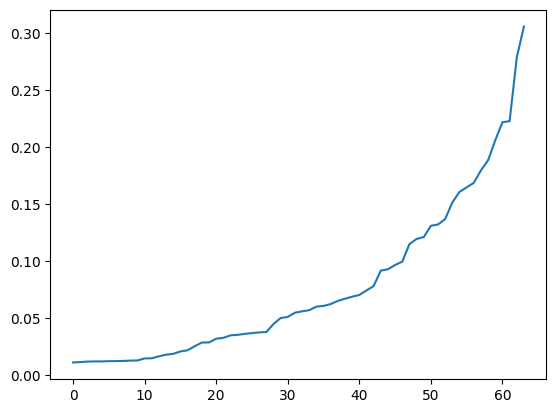

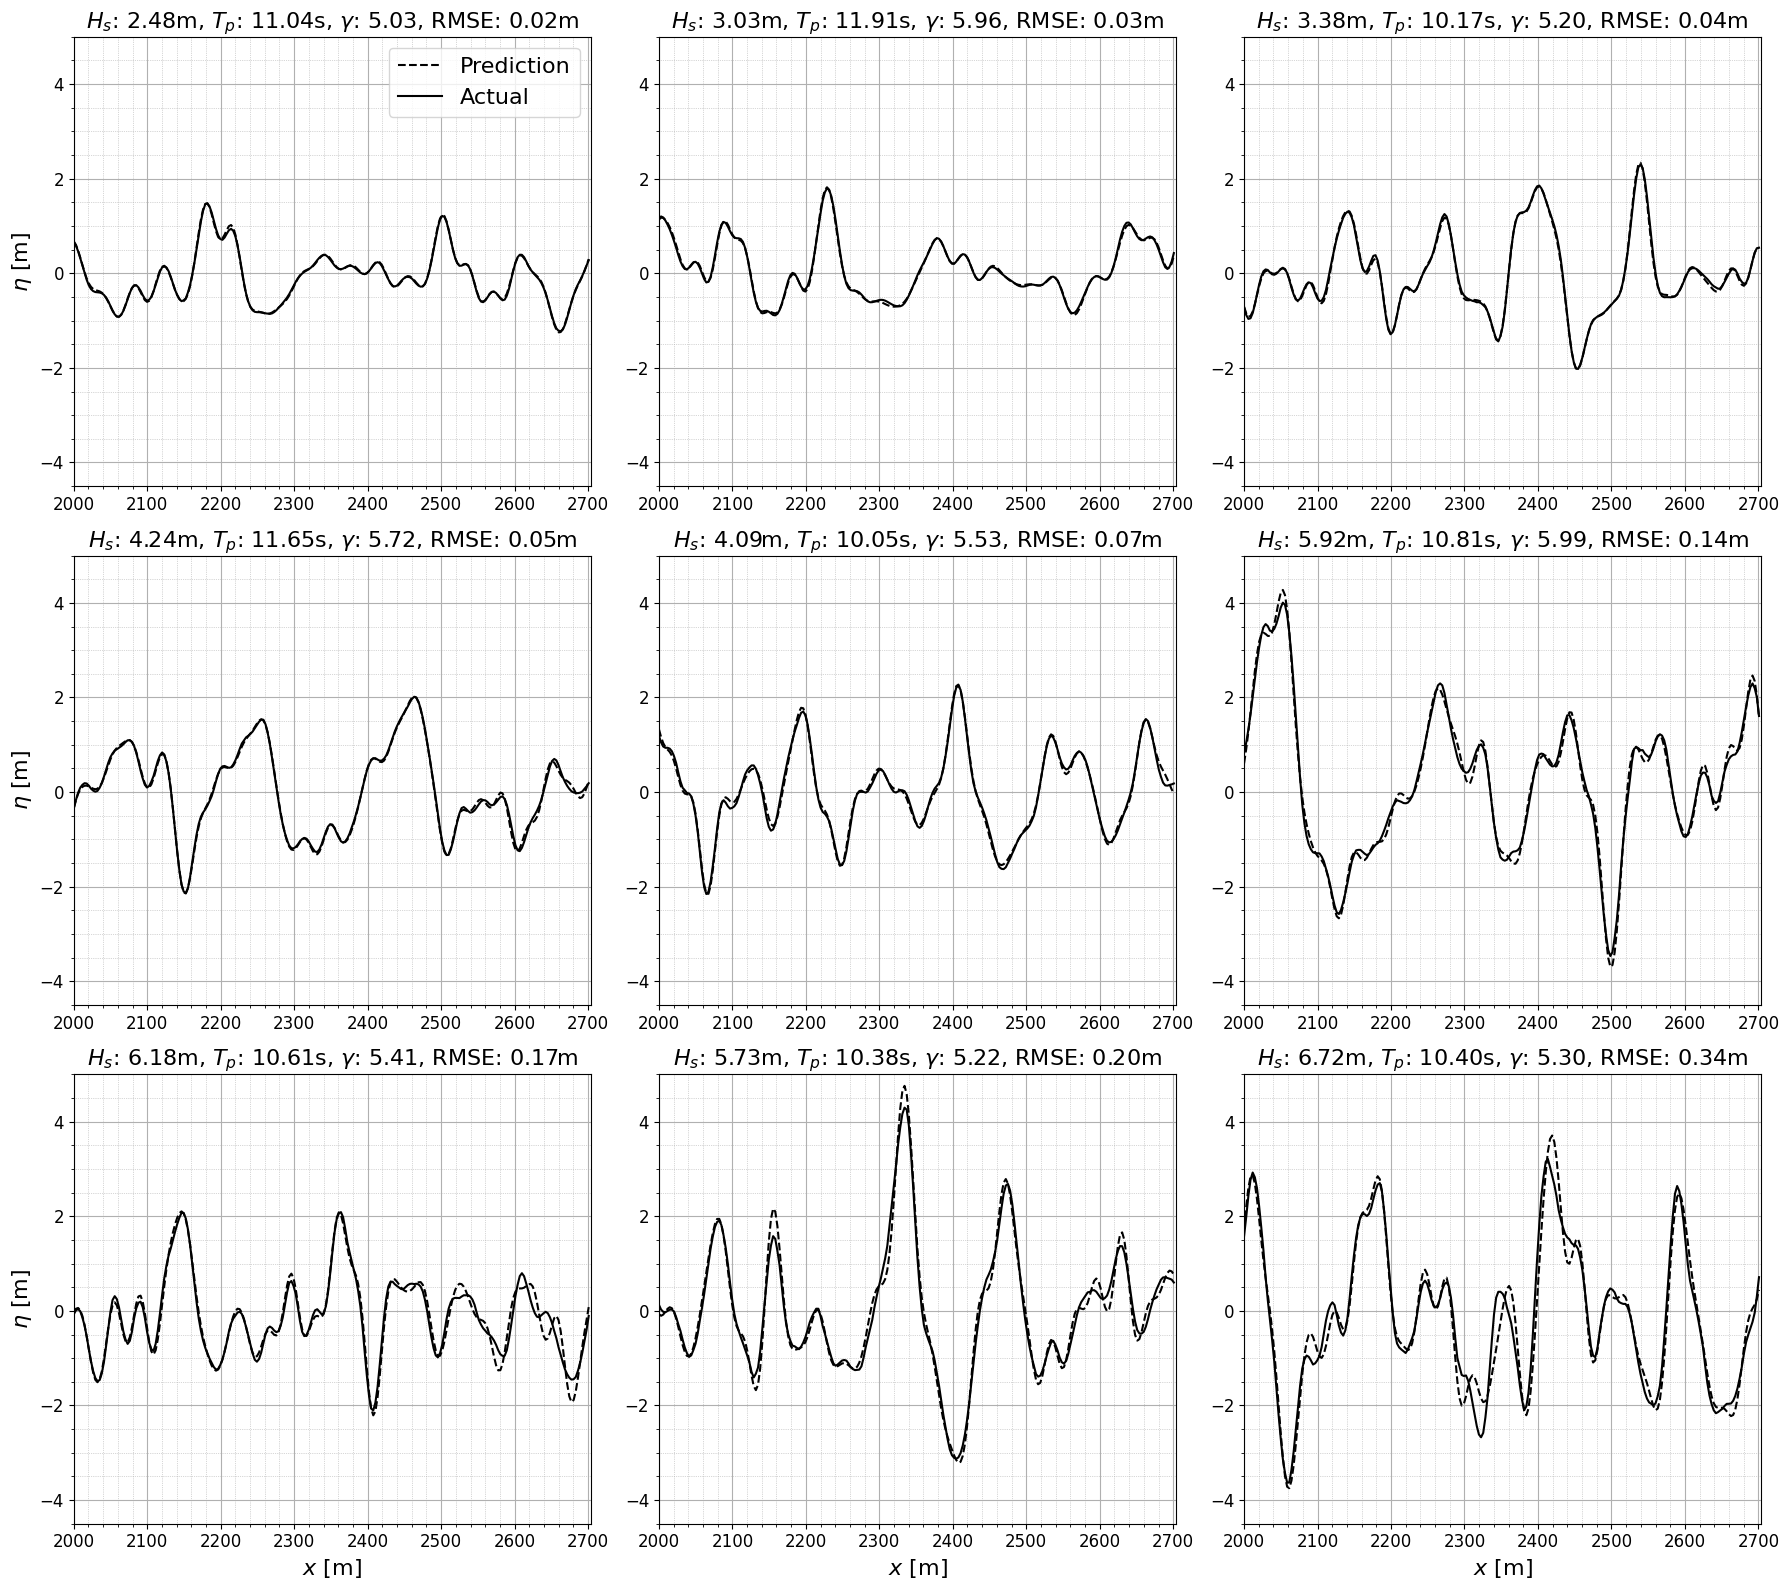

In [71]:
error = np.abs(y_pred[:, :, cut_index:cut_index_2] - y[:, :, cut_index:cut_index_2])
error = np.mean(error, axis=(-2, -1))
plt.plot(error[np.argsort(error)])
print(np.argsort(error))
plt.show()


fig, axs = plt.subplots(3, 3, figsize=(18, 16))
for i, row in enumerate([[21, 11, 31], [30, 41, 49], [60, 59, 26]]):
    for j, col in enumerate(row):
        rand_index = -1
        error = y_pred[col, rand_index, cut_index:cut_index_2] - y[col, rand_index, cut_index:cut_index_2]

        RMSE = np.sqrt(np.mean(error**2))

        axs[i, j].plot(x[cut_index:cut_index_2], y[col, rand_index, cut_index:cut_index_2], "--", color="k", label="Prediction")
        axs[i, j].plot(x[cut_index:cut_index_2], y_pred[col, rand_index, cut_index:cut_index_2], "-", color="k", label="Actual")
        
        axs[i, j].set_xlim(x[cut_index], x[cut_index_2])
        axs[i, j].grid(True, which='major', linewidth=0.8)
        axs[i, j].minorticks_on()
        axs[i, j].grid(True, which='minor', linestyle=':', linewidth=0.5)
        axs[i, j].tick_params(labelsize=12)
        axs[i, j].set_title(fr"$H_s$: {Hs[col]:.2f}m, $T_p$: {Tp[col]:.2f}s, $\gamma$: {gamma[col]:.2f}, RMSE: {RMSE:.2f}m", fontsize=fontsize)
        axs[i, j].set_ylim(-4.5, 5)

        if i == 0 and j == 0:
            axs[i, j].legend(fontsize=fontsize)

        if i == 2:
            axs[i, j].set_xlabel('$x$ [m]', fontsize=fontsize)

        if j == 0:
            axs[i, j].set_ylabel(fr"$\eta$ [m]", fontsize=fontsize)

plt.tight_layout()
plt.savefig("results/example_ml_1d.pdf", dpi=300, bbox_inches='tight')